In [2]:
import torch
import torchvision
from torch import nn
device = torch.device('cuda:2') if torch.cuda.is_available() else "cpu"
device

/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=2)

In [2]:
! which python

/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/bin/python


## Engine

In [2]:
from torch.utils.tensorboard import SummaryWriter
import torchinfo
writer = SummaryWriter()

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [3]:
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float,float]:

    model.train()
    train_loss, train_acc = 0.0,0.0

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def validate_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
    
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            # print(x.device)
            y_pred_logits = model(x)
            
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)
        
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc



    
# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = validate_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    return results

## Dataset Prep

In [3]:
from pathlib import Path

data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")

In [5]:
import os
def walk_through_directory(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_directory(dir_path=data_path)

There are 9 directories and 0 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K'.
There are 0 directories and 14317 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/TUM'.
There are 0 directories and 10407 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/ADI'.
There are 0 directories and 10566 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/BACK'.
There are 0 directories and 11512 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/DEB'.
There are 0 directories and 8763 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/NORM'.
There are 0 directories and 10446 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/STR'.
There are 0 directories and 11557 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/LYM'.
There are 0 directories and 8896 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUC'.
There are 0 directories and 13536 images in '/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUS'.


Random image path: /local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/MUC/MUC-RMKPFSTR.tif
Image class: MUC
Image height: 224
Image width: 224


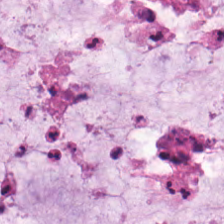

In [6]:
# Printing random image
import random
from PIL import Image

random.seed(42)

image_path_list = list(data_path.glob("*/*.tif"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Dataset prep for 5 clients with IID data of 20,000 images each

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy

BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_SAMPLES=20000
total_samples=100000

data_transform = transforms.Compose([
    transforms.ToTensor()
])

data = datasets.ImageFolder(
    root = data_path,
    transform=data_transform
)

# indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples)))

# train_indices = []
# validate_indices=[]
# test_indices = []

# for i in range(5):
#     train_indices.append(indices[NUM_SAMPLES*(i):NUM_SAMPLES*(i) + 16000])
#     validate_indices.append(indices[NUM_SAMPLES*(i) + 16000: NUM_SAMPLES*(i) + 18000])
#     test_indices.append(indices[NUM_SAMPLES*(i) + 18000: NUM_SAMPLES*(i) + NUM_SAMPLES])

# print("Indices made")

# train_datasets = []
# validate_datasets = []
# test_datasets = []

# for i in range(5):
#     train_datasets.append(Subset(data, train_indices[i]))
#     validate_datasets.append(Subset(data, validate_indices[i]))
#     test_datasets.append(Subset(data, test_indices[i]))

# print("Datasets made")


# print(len(train_datasets[0]), len(test_datasets[0]), len(validate_datasets[0]))

# train_dataloaders = []
# validate_dataloaders = []
# test_dataloaders = []

# for i in range(5):
#     train_dataloaders.append(DataLoader(
#         dataset=train_datasets[i],
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers= NUM_WORKERS,
#         pin_memory = True
#     ))

#     validate_dataloaders.append(DataLoader(
#         dataset=validate_datasets[i],
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers= NUM_WORKERS,
#         pin_memory = True
#     ))

#     test_dataloaders.append(DataLoader(
#         dataset=test_datasets[i],
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers= NUM_WORKERS,
#         pin_memory = True
#     ))

# print("DataLoaders made")
print(data.classes)

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


In [9]:
data.classes

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

## Multi-layer perceptron

In [127]:
NUM_CLASSES = len(data.classes)
TOTAL_PIXELS = torch.numel(data[0][0])

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.layer1 = nn.Linear(
            in_features = TOTAL_PIXELS,
            out_features=200    
        )
        self.layer2 = nn.Linear(
            in_features=200,
            out_features=200
        )
        self.classifier = nn.Linear(
            in_features = 200,
            out_features = NUM_CLASSES
        )

    def forward(self, x):
        return self.classifier(torch.relu(self.layer2(torch.relu(self.layer1(self.flatten(x))))))

In [168]:
model0 = MultiLayerPerceptron()

torchinfo.summary(model0, input_size= data[0][0].unsqueeze(0).shape)

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [1, 9]                    --
├─Flatten: 1-1                           [1, 150528]               --
├─Linear: 1-2                            [1, 200]                  30,105,800
├─Linear: 1-3                            [1, 200]                  40,200
├─Linear: 1-4                            [1, 9]                    1,809
Total params: 30,147,809
Trainable params: 30,147,809
Non-trainable params: 0
Total mult-adds (M): 30.15
Input size (MB): 0.60
Forward/backward pass size (MB): 0.00
Params size (MB): 120.59
Estimated Total Size (MB): 121.20

In [152]:
from torch.utils.tensorboard import SummaryWriter
import torchinfo


def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [153]:
from typing import Type

class Client:
    def __init__(self, 
                model_type: Type[nn.Module], 
                loss_fn: Type[nn.Module],
                optimizer: Type[torch.optim.Optimizer],
                train_dataloader: Type[DataLoader],
                validate_dataloader: Type[DataLoader],
                test_dataloader: Type[DataLoader],
                lr
            ):
        self.model = model_type().to(device)
        self.loss_fn = loss_fn()
        self.optimizer = optimizer(self.model.parameters(), lr)
        self.test_dataloader = test_dataloader
        self.validate_dataloader = validate_dataloader
        self.train_dataloader = train_dataloader
        self.lr = lr
    
    def refresh(self):
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.__class__()
        self.optimizer = self.optimizer.__class__(self.model.parameters(), self.lr)
    
    def train_step(self):
        self.model.train()

        train_loss, train_acc = 0.0, 0.0

        for batch, (x,y) in enumerate(self.train_dataloader):
            x,y = x.to(device), y.to(device)
            y_pred = self.model(x)

            loss = self.loss_fn(y_pred, y)
            train_loss += loss.item()

            self.optimizer.zero_grad()

            loss.backward()

            self.optimizer.step()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        train_loss /= len(self.train_dataloader)
        train_acc /= len(self.train_dataloader)
        
        return train_loss, train_acc

    
    def validate_step(self):

        self.model.eval()

        test_loss, test_acc = 0.0,0.0
        
        with torch.inference_mode():

            for batch, (x,y) in enumerate(self.validate_dataloader):
                x, y = x.to(device), y.to(device)

                y_pred_logits = self.model(x)

                loss = self.loss_fn(y_pred_logits, y)
                test_loss += loss.item()

                y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
                test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)

        
        test_loss /= len(self.validate_dataloader)
        test_acc /= len(self.validate_dataloader)

    
        return test_loss, test_acc


    def train(self, epochs, writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:

        results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
        }

        for epoch in range(epochs):
            train_loss, train_acc = self.train_step()

            test_loss, test_acc = self.validate_step()

            # print(
            #     f"Epoch: {epoch+1} | "
            #     f"train_loss: {train_loss:.4f} | "
            #     f"train_acc: {train_acc:.4f} | "
            #     f"test_loss: {test_loss:.4f} | "
            #     f"test_acc: {test_acc:.4f}"
            # )
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

            if writer:
                # Add results to SummaryWriter
                writer.add_scalars(main_tag="Loss", 
                                tag_scalar_dict={"train_loss": train_loss,
                                                    "test_loss": test_loss},
                                global_step=epoch)
                writer.add_scalars(main_tag="Accuracy", 
                                tag_scalar_dict={"train_acc": train_acc,
                                                    "test_acc": test_acc}, 
                                global_step=epoch)

                # Close the writer
                writer.close()
            else:
                pass
        ### End new ###

        return results


In [169]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy
class Server:
    def __init__(self,
        num_clients,
        model_type: Type[nn.Module], 
        loss_fn: Type[nn.Module],
        optimizer: Type[torch.optim.Optimizer],
        lr
        ):

        self.NUM_CLIENTS = num_clients
        self.model_type = model_type
        self.model = model_type().to(device)
        self.loss_fn_type = loss_fn
        self.optimizer_type = optimizer
        train_dataloaders, validate_dataloaders, test_dataloaders = self.make_data(batch_size=32, num_workers=2)
        self.clients = []
        for i in range(self.NUM_CLIENTS):
            new_client = Client(model_type=self.model_type, 
                                loss_fn = self.loss_fn_type,
                                optimizer=self.optimizer_type,
                                train_dataloader = train_dataloaders[i],
                                validate_dataloader=validate_dataloaders[i],
                                test_dataloader=test_dataloaders[i],
                                lr=0.01)
            self.clients.append(new_client)
        


    def make_data(self,
        batch_size,
        num_workers
        ):

        data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")
        BATCH_SIZE = batch_size
        NUM_WORKERS = num_workers
        NUM_CLIENTS = self.NUM_CLIENTS

        data_transform = transforms.Compose([
            transforms.ToTensor()
        ])

        data = datasets.ImageFolder(
            root = data_path,
            transform=data_transform
        )

        total_samples=len(data)
        NUM_SAMPLES=total_samples/NUM_CLIENTS
        
        indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples)))

        train_indices = []
        validate_indices=[]
        test_indices = []

        NUM_SAMPLES = int(NUM_SAMPLES)
        train_split, val_split, test_split = int(0.8*NUM_SAMPLES), int(0.1*NUM_SAMPLES), int(0.1*NUM_SAMPLES)

        for i in range(NUM_CLIENTS):
            train_indices.append(indices[NUM_SAMPLES*(i):NUM_SAMPLES*(i) + train_split])
            validate_indices.append(indices[NUM_SAMPLES*(i) + train_split: NUM_SAMPLES*(i) + train_split+val_split])
            test_indices.append(indices[NUM_SAMPLES*(i) + train_split+val_split: NUM_SAMPLES*(i) + NUM_SAMPLES])

        # print("Indices made")

        train_datasets = []
        validate_datasets = []
        test_datasets = []

        for i in range(NUM_CLIENTS):
            train_datasets.append(Subset(data, train_indices[i]))
            validate_datasets.append(Subset(data, validate_indices[i]))
            test_datasets.append(Subset(data, test_indices[i]))

        # print("Datasets made")


        # print(len(train_datasets[0]), len(test_datasets[0]), len(validate_datasets[0]))

        train_dataloaders = []
        validate_dataloaders = []
        test_dataloaders = []

        for i in range(NUM_CLIENTS):
            train_dataloaders.append(DataLoader(
                dataset=train_datasets[i],
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers= NUM_WORKERS,
                pin_memory = True
            ))

            validate_dataloaders.append(DataLoader(
                dataset=validate_datasets[i],
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers= NUM_WORKERS,
                pin_memory = True
            ))

            test_dataloaders.append(DataLoader(
                dataset=test_datasets[i],
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers= NUM_WORKERS,
                pin_memory = True
            ))
            
        return train_dataloaders, validate_dataloaders, test_dataloaders
        # print("DataLoaders made")
    
    def run(self,
        server_epochs,
        client_epochs,
        folder_path):

        for epoch in tqdm(range(server_epochs)):
            train_loss, validate_loss = 0,0
            train_acc, validate_acc = 0,0
            for j in range(self.NUM_CLIENTS):
                results = self.clients[i].train(epochs = client_epochs, writer = None)
                train_loss += results["train_loss"][-1]
                validate_loss += results["test_loss"][-1]
                train_acc += results["train_acc"][-1]
                validate_acc += results["test_acc"][-1]

                p = folder_path/f"models/client-{j}/"
                p.mkdir(parents=True, exist_ok=True)
                file_path = p/f"epoch-{epoch}.pt"

                torch.save(obj=self.clients[j].model.state_dict(), f=file_path)
            train_loss /= self.NUM_CLIENTS
            validate_loss /= self.NUM_CLIENTS
            train_acc /= self.NUM_CLIENTS
            validate_acc /= self.NUM_CLIENTS

            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"validate_loss: {validate_loss:.4f} | "
                f"validate_acc: {validate_acc:.4f}"
            )

            self.model.load_state_dict(self.clients[0].model.state_dict())
            for j in range(1, self.NUM_CLIENTS):
                for(key, value) in self.model.state_dict().items():
                    self.model.state_dict()[key].copy_(self.clients[j].model.state_dict()[key] + value)
            
            for (key, value) in self.model.state_dict().items():
                self.model.state_dict()[key].copy_(value/self.NUM_CLIENTS)

            for j in range(self.NUM_CLIENTS):
                self.clients[j].model.load_state_dict(self.model.state_dict())
                self.clients[j].refresh()
                
            
            final_loss, final_acc = 0,0
            for client in self.clients:
                temp_loss, temp_acc = client.validate_step()
                final_loss += temp_loss
                final_acc += temp_acc
            
            final_loss /= self.NUM_CLIENTS
            final_acc /= self.NUM_CLIENTS

            print(
                "Aggregated Model"
                f"Epoch: {epoch+1} | "
                f"validate_loss: {final_loss:.4f} | "
                f"validate_acc: {final_acc:.4f}"
            )        

            p = folder_path/"models/server/"
            p.mkdir(parents = True, exist_ok = True)
            p_file = p/f"epoch-{epoch}.pt"
            torch.save(obj=self.model.state_dict(), f=p_file)

In [170]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
server = Server(
    num_clients=5,
    model_type= MultiLayerPerceptron,
    loss_fn=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    lr=0.01
)

In [171]:
server.run(
    server_epochs=20,
    client_epochs=5,
    folder_path = Path("MultilayerPerceptron/client-5-server-20")
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5851 | train_acc: 0.4002 | validate_loss: 1.6394 | validate_acc: 0.3682
Aggregated ModelEpoch: 1 | validate_loss: 2.1904 | validate_acc: 0.1634


  5%|▌         | 1/20 [04:41<1:29:06, 281.39s/it]

Epoch: 2 | train_loss: 1.4997 | train_acc: 0.4368 | validate_loss: 1.5497 | validate_acc: 0.4137
Aggregated ModelEpoch: 2 | validate_loss: 2.0956 | validate_acc: 0.2045


 10%|█         | 2/20 [09:23<1:24:37, 282.10s/it]

Epoch: 3 | train_loss: 1.4742 | train_acc: 0.4434 | validate_loss: 1.5705 | validate_acc: 0.4226
Aggregated ModelEpoch: 3 | validate_loss: 1.9586 | validate_acc: 0.2770


 15%|█▌        | 3/20 [14:06<1:20:00, 282.37s/it]

Epoch: 4 | train_loss: 1.4507 | train_acc: 0.4543 | validate_loss: 1.4387 | validate_acc: 0.4584
Aggregated ModelEpoch: 4 | validate_loss: 1.8032 | validate_acc: 0.3592


 20%|██        | 4/20 [18:30<1:13:19, 274.96s/it]

Epoch: 5 | train_loss: 1.4335 | train_acc: 0.4627 | validate_loss: 1.5269 | validate_acc: 0.4253
Aggregated ModelEpoch: 5 | validate_loss: 1.6696 | validate_acc: 0.4191


 25%|██▌       | 5/20 [22:57<1:08:03, 272.26s/it]

Epoch: 6 | train_loss: 1.4128 | train_acc: 0.4679 | validate_loss: 1.4849 | validate_acc: 0.4279
Aggregated ModelEpoch: 6 | validate_loss: 1.5714 | validate_acc: 0.4509


 30%|███       | 6/20 [27:48<1:04:59, 278.57s/it]

Epoch: 7 | train_loss: 1.3960 | train_acc: 0.4746 | validate_loss: 1.5913 | validate_acc: 0.4199
Aggregated ModelEpoch: 7 | validate_loss: 1.5123 | validate_acc: 0.4540


 35%|███▌      | 7/20 [33:02<1:02:52, 290.23s/it]

Epoch: 8 | train_loss: 1.3815 | train_acc: 0.4803 | validate_loss: 1.4389 | validate_acc: 0.4541
Aggregated ModelEpoch: 8 | validate_loss: 1.4606 | validate_acc: 0.4647


 40%|████      | 8/20 [38:10<59:07, 295.67s/it]  

Epoch: 9 | train_loss: 1.3726 | train_acc: 0.4849 | validate_loss: 1.4278 | validate_acc: 0.4573
Aggregated ModelEpoch: 9 | validate_loss: 1.4177 | validate_acc: 0.4824


 45%|████▌     | 9/20 [43:33<55:49, 304.47s/it]

Epoch: 10 | train_loss: 1.3470 | train_acc: 0.4912 | validate_loss: 1.3999 | validate_acc: 0.4803
Aggregated ModelEpoch: 10 | validate_loss: 1.3918 | validate_acc: 0.4895


 50%|█████     | 10/20 [48:57<51:42, 310.22s/it]

Epoch: 11 | train_loss: 1.3194 | train_acc: 0.5041 | validate_loss: 1.5214 | validate_acc: 0.4361
Aggregated ModelEpoch: 11 | validate_loss: 1.3626 | validate_acc: 0.4948


 55%|█████▌    | 11/20 [54:20<47:07, 314.17s/it]

Epoch: 12 | train_loss: 1.3002 | train_acc: 0.5109 | validate_loss: 1.3921 | validate_acc: 0.4754
Aggregated ModelEpoch: 12 | validate_loss: 1.3406 | validate_acc: 0.4992


 60%|██████    | 12/20 [59:40<42:07, 315.91s/it]

Epoch: 13 | train_loss: 1.2793 | train_acc: 0.5163 | validate_loss: 1.5042 | validate_acc: 0.4464
Aggregated ModelEpoch: 13 | validate_loss: 1.3335 | validate_acc: 0.5010


 65%|██████▌   | 13/20 [1:05:08<37:17, 319.70s/it]

Epoch: 14 | train_loss: 1.2536 | train_acc: 0.5296 | validate_loss: 1.3848 | validate_acc: 0.4878
Aggregated ModelEpoch: 14 | validate_loss: 1.3109 | validate_acc: 0.5085


 70%|███████   | 14/20 [1:10:42<32:24, 324.02s/it]

Epoch: 15 | train_loss: 1.2356 | train_acc: 0.5354 | validate_loss: 1.4888 | validate_acc: 0.4502
Aggregated ModelEpoch: 15 | validate_loss: 1.3132 | validate_acc: 0.5035


 75%|███████▌  | 15/20 [1:17:16<28:45, 345.05s/it]

Epoch: 16 | train_loss: 1.2121 | train_acc: 0.5423 | validate_loss: 1.3980 | validate_acc: 0.4871
Aggregated ModelEpoch: 16 | validate_loss: 1.3194 | validate_acc: 0.4981


 80%|████████  | 16/20 [1:23:55<24:05, 361.42s/it]

Epoch: 17 | train_loss: 1.2111 | train_acc: 0.5426 | validate_loss: 1.4514 | validate_acc: 0.4883
Aggregated ModelEpoch: 17 | validate_loss: 1.2820 | validate_acc: 0.5194


 85%|████████▌ | 17/20 [1:30:33<18:36, 372.27s/it]

Epoch: 18 | train_loss: 1.1840 | train_acc: 0.5553 | validate_loss: 1.4288 | validate_acc: 0.4710
Aggregated ModelEpoch: 18 | validate_loss: 1.2838 | validate_acc: 0.5169


 90%|█████████ | 18/20 [1:36:54<12:29, 374.92s/it]

Epoch: 19 | train_loss: 1.1750 | train_acc: 0.5564 | validate_loss: 1.5807 | validate_acc: 0.4494
Aggregated ModelEpoch: 19 | validate_loss: 1.3121 | validate_acc: 0.5055


 95%|█████████▌| 19/20 [1:43:34<06:22, 382.64s/it]

Epoch: 20 | train_loss: 1.1639 | train_acc: 0.5638 | validate_loss: 1.3717 | validate_acc: 0.4961
Aggregated ModelEpoch: 20 | validate_loss: 1.2996 | validate_acc: 0.5115


100%|██████████| 20/20 [1:51:06<00:00, 333.32s/it]


In [142]:
model0 = MultiLayerPerceptron().to(device)
model1 = MultiLayerPerceptron().to(device)
len(model0.state_dict())
for (key, value) in model0.state_dict().items():
    l = model0.state_dict()[key]
    model0.state_dict()[key].copy_(model1.state_dict()[key] + value)
    print(l == model0.state_dict()[key])

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:2')
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, Tru

In [182]:
NUM_CLASSES = len(data.classes)
class ConvolutionalNN(nn.Module):
    def __init__(self, input_channels: int = 3, output_shape: int = NUM_CLASSES):
        super().__init__()
        self.conv_block_1 = nn.Conv2d(
            in_channels= input_channels,
            out_channels= 32,
            kernel_size=5,
            stride=1,
            padding=2
        )

        self.conv_block_2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=2
        )

        self.linear_layer = nn.Linear(
            in_features= 64*56*56,
            out_features = 512,
        )

        self.classifier = nn.Linear(
            in_features = 512,
            out_features = NUM_CLASSES
        )

        self.max_pool2d = nn.MaxPool2d(2)

    def forward(self, x):
        return self.classifier(self.linear_layer(nn.Flatten()(self.max_pool2d(self.conv_block_2(self.max_pool2d(self.conv_block_1(x)))))))


        

In [183]:
model1 = ConvolutionalNN(input_channels=3, output_shape = len(data.classes))
model1(data[0][0].unsqueeze(dim=0))

tensor([[-0.1377,  0.1696,  0.1024, -0.0392, -0.1145,  0.0812,  0.0278, -0.0043,
          0.0469]], grad_fn=<AddmmBackward0>)

In [190]:
server = Server(
    num_clients=5,
    model_type= ConvolutionalNN,
    loss_fn=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001
)

server.run(
    server_epochs=10,
    client_epochs=5,
    folder_path = Path("ConvoultionalNN/client-1-server-20")
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 127.1153 | train_acc: 0.6593 | validate_loss: 1550.0876 | validate_acc: 0.4531
Aggregated ModelEpoch: 1 | validate_loss: 100.4556 | validate_acc: 0.1756


 10%|█         | 1/10 [09:05<1:21:52, 545.83s/it]

Epoch: 2 | train_loss: 460.4010 | train_acc: 0.5386 | validate_loss: 411.6838 | validate_acc: 0.4837
Aggregated ModelEpoch: 2 | validate_loss: 470.2531 | validate_acc: 0.1094


 20%|██        | 2/10 [18:26<1:13:54, 554.36s/it]

Epoch: 3 | train_loss: 1716.0396 | train_acc: 0.5380 | validate_loss: 582.1703 | validate_acc: 0.5104
Aggregated ModelEpoch: 3 | validate_loss: 718.0280 | validate_acc: 0.1095


 30%|███       | 3/10 [27:33<1:04:18, 551.15s/it]

Epoch: 4 | train_loss: 85662.7996 | train_acc: 0.5582 | validate_loss: 584.8341 | validate_acc: 0.4876
Aggregated ModelEpoch: 4 | validate_loss: 361.9335 | validate_acc: 0.2191


 40%|████      | 4/10 [36:35<54:45, 547.65s/it]  

Epoch: 5 | train_loss: 134366.0378 | train_acc: 0.5238 | validate_loss: 1177.8940 | validate_acc: 0.4629
Aggregated ModelEpoch: 5 | validate_loss: 556.3439 | validate_acc: 0.1675


 50%|█████     | 5/10 [45:25<45:05, 541.13s/it]

Epoch: 6 | train_loss: 492.6015 | train_acc: 0.6126 | validate_loss: 455.1253 | validate_acc: 0.4917
Aggregated ModelEpoch: 6 | validate_loss: 538.6828 | validate_acc: 0.2604


 60%|██████    | 6/10 [54:29<36:08, 542.11s/it]

Epoch: 7 | train_loss: 185.4291 | train_acc: 0.6792 | validate_loss: 248.2535 | validate_acc: 0.4764
Aggregated ModelEpoch: 7 | validate_loss: 493.3045 | validate_acc: 0.1724


 70%|███████   | 7/10 [1:03:25<27:00, 540.26s/it]

Epoch: 8 | train_loss: 145352.2975 | train_acc: 0.6115 | validate_loss: 6023.2464 | validate_acc: 0.4819
Aggregated ModelEpoch: 8 | validate_loss: 510.5599 | validate_acc: 0.1690


 80%|████████  | 8/10 [1:12:26<18:01, 540.54s/it]

Epoch: 9 | train_loss: 1174.2341 | train_acc: 0.6169 | validate_loss: 580.6774 | validate_acc: 0.5277
Aggregated ModelEpoch: 9 | validate_loss: 612.6037 | validate_acc: 0.1560


 90%|█████████ | 9/10 [1:21:40<09:04, 544.60s/it]

Epoch: 10 | train_loss: 159872.9237 | train_acc: 0.6027 | validate_loss: 3151.5656 | validate_acc: 0.5028
Aggregated ModelEpoch: 10 | validate_loss: 345.8426 | validate_acc: 0.2141


100%|██████████| 10/10 [1:30:55<00:00, 545.59s/it]


In [1]:
data.classes

NameError: name 'data' is not defined